## **Imports**

In [1]:
import os
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import zscore, uniform

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)

## **Paths & Global Variables**

In [2]:
ROOT_PATH = r"C:\Users\mario\OneDrive\Documents\Work\Side Hustles\Kaggle\titanic"
TARGET_VAR = "survived"
COLINEARITY_THRESHOLD = 0.4

import sys

sys.path.append(ROOT_PATH)

from titanic.config import PROCESSED_DATA_DIR, MODELS_DIR

2025-03-04 15:52:21.699 | INFO     | titanic.config:<module>:9 - PROJ_ROOT path is: C:\Users\mario\OneDrive\Documents\Work\Side Hustles\Kaggle\titanic


## **Reading Data**

In [3]:
os.chdir(PROCESSED_DATA_DIR)

features_selected = pd.read_json("log_reg_features.json").index.to_list()

X_train = pd.read_parquet("X_train.parquet", columns=features_selected)
y_train = pd.read_parquet("y_train.parquet")

X_test = pd.read_parquet("X_val.parquet", columns=features_selected)
y_test = pd.read_parquet("y_val.parquet")

X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)

# **Logistic Regression**

## **Assumptions** 🔴

In [4]:
# Binary target
print(y.survived.value_counts())

survived
False    549
True     340
Name: count, dtype: int64


In [5]:
# Independent observations
X.index.nunique() == X.shape[0]

True

In [6]:
# Large enough sample
# At least 10 samples per feature for the smallest class in the outcome variable.
max_features = min(y_train.survived.value_counts() / 10)
num_features = X_train.shape[1]
print(max_features)
print(num_features)
X.shape[1] <= max_features

27.2
12


True

<Axes: >

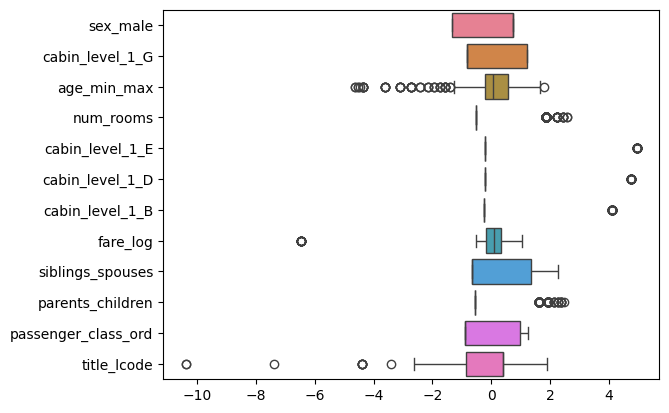

In [7]:
# No influential outliers
sns.boxplot(data=np.log(X_train.iloc[:, :] + 0.01).apply(zscore), orient="h")

In [8]:
# Features Linearly Related to Log-odds
X_y = pd.concat([X_train, y_train], axis=1)
X_y.head()

,sex_male,cabin_level_1_G,age_min_max,num_rooms,cabin_level_1_E,cabin_level_1_D,cabin_level_1_B,fare_log,siblings_spouses,parents_children,passenger_class_ord,title_lcode,survived
passenger_id,,,,,,,,,,,,,
622,True,False,0.523988,1,False,True,False,3.980694,1,0,1,12,True
482,True,False,0.379828,0,False,False,False,0.000000,0,0,2,12,False
528,True,False,0.520305,1,False,False,False,5.406181,0,0,1,12,False
436,False,False,0.173243,2,False,False,True,4.795791,1,2,1,9,True
798,False,True,0.386196,0,False,False,False,2.270403,0,0,0,13,True


<Axes: xlabel='fare_log', ylabel='survived'>

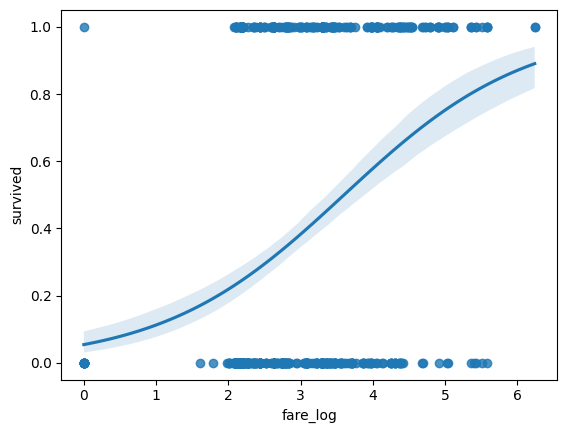

In [9]:
sns.regplot(
    x="fare_log",
    y=TARGET_VAR,
    data=X_y,
    logistic=True,
)

<Axes: >

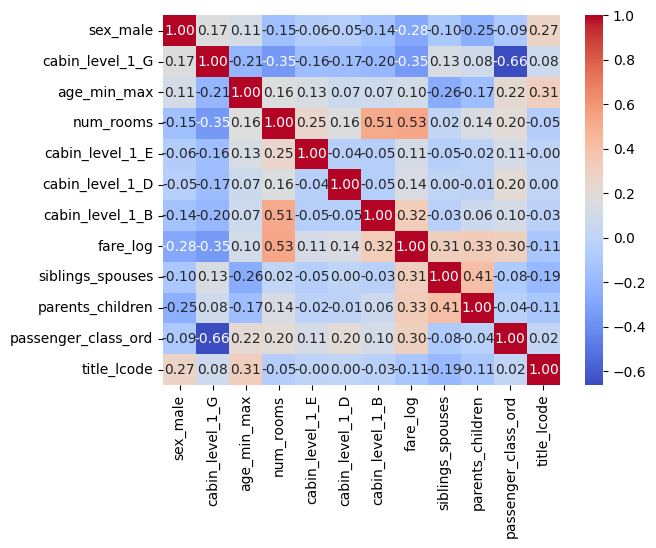

In [10]:
corr_matrix = X_train.corr(method="pearson")
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")

<Axes: >

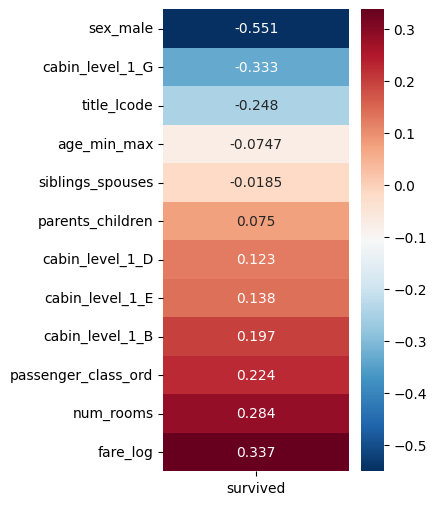

In [11]:
corr_X_y_matrix = X_y.corr()

# Isolate the column corresponding to `exam_score`
corr_target = corr_X_y_matrix[[TARGET_VAR]].drop(labels=[TARGET_VAR])
corr_target.sort_values(TARGET_VAR, inplace=True)

plt.figure(figsize=(3, 6))
sns.heatmap(corr_target, annot=True, fmt=".3", cmap="RdBu_r")

In [12]:
# Variables with high correlation with each other should be removed (r > 0.75)
corr_target.reset_index(inplace=True)
corr_target.columns = ["feature", "corr_target"]
mcol_df = pd.DataFrame()

# Loop over bottom diagonal of correlation matrix
for i in range(len(corr_matrix.columns)):
    for j in range(i):

        # Print variables with high correlation
        if abs(corr_matrix.iloc[i, j]) > COLINEARITY_THRESHOLD:
            var_1 = corr_matrix.columns[i]
            var_2 = corr_matrix.columns[j]
            corr = corr_matrix.iloc[i, j]
            temp_df = pd.DataFrame({"var1": [var_1], "var2": [var_2], "corr": [corr]})
            mcol_df = pd.concat([temp_df, mcol_df])

for var in ["var1", "var2"]:
    mcol_df = pd.merge(
        mcol_df, corr_target, left_on=var, right_on="feature", how="left"
    )
    mcol_df.drop(columns=["feature"], inplace=True)
    mcol_df.rename(columns={"corr_target": f"corr_target_{var[-1]}"}, inplace=True)

mcol_df["col_to_drop"] = mcol_df.apply(
    lambda x: (
        x["var1"] if abs(x["corr_target_1"]) < abs(x["corr_target_2"]) else x["var2"]
    ),
    axis=1,
)
mcol_df

,var1,var2,corr,corr_target_1,corr_target_2,col_to_drop
0,passenger_class_ord,cabin_level_1_G,-0.662381,0.223754,-0.332638,passenger_class_ord
1,parents_children,siblings_spouses,0.410283,0.074995,-0.018486,siblings_spouses
2,fare_log,num_rooms,0.529134,0.337468,0.283692,num_rooms
3,cabin_level_1_B,num_rooms,0.513494,0.197149,0.283692,cabin_level_1_B


In [13]:
cols_to_remove = ["passenger_class_ord"]
X_train.drop(columns=cols_to_remove, inplace=True)
X_test.drop(columns=cols_to_remove, inplace=True)

## **Model Fitting**

In [14]:
log_reg = LogisticRegression(class_weight="balanced", solver="liblinear")
log_reg.get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

## **Hyperparameter Tuning**

In [15]:
distributions = {"penalty": ["l1", "l2"], "C": uniform(loc=0, scale=100)}

In [16]:
clf = RandomizedSearchCV(log_reg, distributions, n_iter=30, cv=10, scoring="roc_auc")
clf.get_params()

{'cv': 10,
 'error_score': nan,
 'estimator__C': 1.0,
 'estimator__class_weight': 'balanced',
 'estimator__dual': False,
 'estimator__fit_intercept': True,
 'estimator__intercept_scaling': 1,
 'estimator__l1_ratio': None,
 'estimator__max_iter': 100,
 'estimator__multi_class': 'deprecated',
 'estimator__n_jobs': None,
 'estimator__penalty': 'l2',
 'estimator__random_state': None,
 'estimator__solver': 'liblinear',
 'estimator__tol': 0.0001,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': LogisticRegression(class_weight='balanced', solver='liblinear'),
 'n_iter': 30,
 'n_jobs': None,
 'param_distributions': {'penalty': ['l1', 'l2'],
  'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x2635e853cb0>},
 'pre_dispatch': '2*n_jobs',
 'random_state': None,
 'refit': True,
 'return_train_score': False,
 'scoring': 'roc_auc',
 'verbose': 0}

In [17]:
clf.fit(X_train, y_train.values.ravel())
best_model = clf.best_estimator_
print(best_model)
print(clf.best_params_)

LogisticRegression(C=np.float64(1.861846374562759), class_weight='balanced',
                   penalty='l1', solver='liblinear')
{'C': np.float64(1.861846374562759), 'penalty': 'l1'}


## **Model Testing**

In [18]:
THRESHOLD = 0.5

In [19]:
y_predicted_probs = best_model.predict_proba(X_test)[:, 1]
if THRESHOLD == 0.5:
    y_predicted = best_model.predict(X_test)
else:
    y_predicted = (y_predicted_probs > THRESHOLD) * 1.0

In [20]:
y_predicted_df = pd.DataFrame(y_predicted, columns=["predicted"], index=X_test.index)
y_predicted_probs_df = pd.DataFrame(
    y_predicted_probs, columns=["probability"], index=X_test.index
)
y_predicted_df = pd.concat([y_predicted_df, y_predicted_probs_df], axis=1)
y_predicted_df.head()

,predicted,probability
passenger_id,,
161,False,0.101403
127,False,0.249692
429,False,0.249692
423,False,0.121109
566,False,0.119682


## **Evaluation Metrics**

In [21]:
best_score = clf.best_score_
test_score = clf.score(X_test, y_test)
print(best_score)
print(test_score)

0.8630997474747474
0.8447860962566845


In [22]:
test_conf_matrix = pd.DataFrame(
    confusion_matrix(y_test, y_predicted),
    index=["actual no", "actual yes"],
    columns=["predicted no", "predicted yes"],
)

test_conf_matrix

,predicted no,predicted yes
actual no,88,22
actual yes,15,53


In [23]:
metrics_dict = {
    "Accuracy": accuracy_score(y_test, y_predicted),
    "Precision": precision_score(y_test, y_predicted),
    "Recall": recall_score(y_test, y_predicted),
    "F1 Score": f1_score(y_test, y_predicted),
}

metrics_df = pd.DataFrame(
    metrics_dict.values(), index=metrics_dict.keys(), columns=["Value"]
)

roc_auc = roc_auc_score(y_test, y_predicted_probs)
gini = 2 * roc_auc - 1

metrics_df.loc["ROC AUC"] = roc_auc
metrics_df.loc["Gini"] = gini

metrics_df

,Value
Accuracy,0.792135
Precision,0.706667
Recall,0.779412
F1 Score,0.741259
ROC AUC,0.844786
Gini,0.689572


## **Feature Importance**

C:\Users\mario\AppData\Local\Temp\ipykernel_27368\2342241069.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


<Axes: xlabel='Coefficient', ylabel='Feature'>

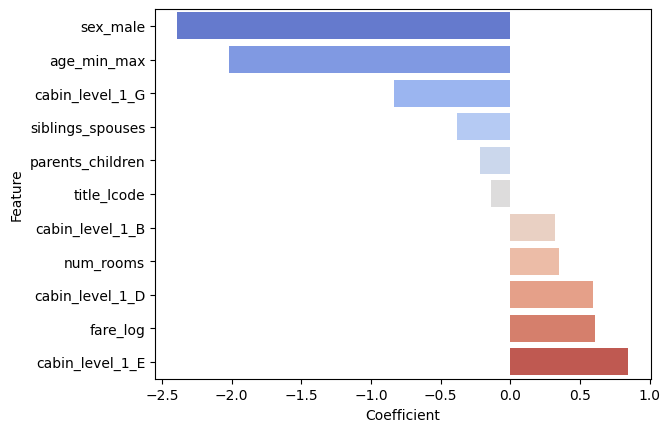

In [24]:
coefficients_df = pd.DataFrame(
    {"Feature": best_model.feature_names_in_, "Coefficient": best_model.coef_.flatten()}
)

sns.barplot(
    x="Coefficient",
    y="Feature",
    data=coefficients_df.sort_values("Coefficient"),
    palette="coolwarm",
)

## **Model & Prediction Export**

In [25]:
os.chdir(MODELS_DIR)
# Save model
joblib.dump(best_model, "log_reg-model.joblib")
y_predicted_df.to_parquet("log_reg-y_predicted.parquet")